In [1]:
#adapted from ASI workshop: advection
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
#various limiters used in second order schemes using linear reconstruction
def minmod(x1,x2):
    if (x1*x2>0):
        y=min(abs(x1),abs(x2))*np.sign(x1)
    else:
        y=0.0
    return y

def MClim(x1,x2):
    y = minmod( 2.*minmod(x1,x2), 0.5*(x1+x2) )
    return y

def vanleer(x1,x2):
    if (x1*x2>0):
        y = 2.*x1*x2/(x1+x2)
    else:
        y = 0.0
    return y

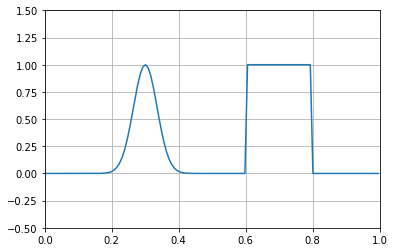

In [3]:
#----start of the main program----
n=128 # number of grid points
dx = 1.0/n
x=np.arange(0.0,1.0,dx); x=x+0.5*dx #cell-centered grid; be careful abt grid centering
f = np.exp(-(x-0.3)**2/0.05**2) # set up initial function
for i in range(n):
    if (f[i]<1.e-10):
        f[i] = 1.e-10
    if (x[i]>0.6 and x[i]<0.8):
        f[i] = 1.0
plt.plot(x,f,'-') #plot initial f
plt.axis([0,1,-0.5,1.5])
plt.grid()
plt.show()
#evolve
v=-1.0; cfl=0.5; dt=cfl*dx/abs(v); time=0.0; tend=1.0

In [4]:
def updated_f(f, v, dt, dx, method = 'donor-cell', limiter = 'None'):
    n = np.size(f)
    fnew = 0.*f
    for i in range(n):
        if (method == 'donor-cell'):
            if (v > 0):
                if (i != 0):
                    fnew[i] = f[i] - (v*dt/dx)*(f[i]-f[i-1])
                else:
                    fnew[i] = f[i] - (v*dt/dx)*(f[i]-f[n-1])
            else:
                if (i != n-1):
                    fnew[i] = f[i] - (v*dt/dx)*(f[i+1]-f[i])
                else:
                    fnew[i] = f[i] - (v*dt/dx)*(f[0]-f[i])
        elif (method == 'Lax'):
            if (i != n-1 and i != 0):
                fnew[i] = 0.5*(f[i+1]+f[i-1]) - (0.5*v*dt/dx)*(f[i+1]-f[i-1])
            if (i == n-1):
                fnew[i] = 0.5*(f[0]+f[i-1]) - (0.5*v*dt/dx)*(f[0]-f[i-1])
            if (i == 0):
                fnew[i] = 0.5*(f[i+1]+f[n-1]) - (0.5*v*dt/dx)*(f[i+1]-f[n-1])
        elif (method == 'Lax-Wendroff'):
            if (i != n-1):
                fp = 0.5*(f[i+1]+f[i]) - (0.5*v*dt/dx)*(f[i+1]-f[i])
            else:
                fp = 0.5*(f[0]+f[i]) - (0.5*v*dt/dx)*(f[0]-f[i])
            if (i != 0):
                fm = 0.5*(f[i-1]+f[i]) - (0.5*v*dt/dx)*(f[i]-f[i-1])
            else:
                fm = 0.5*(f[n-1]+f[i]) - (0.5*v*dt/dx)*(f[i]-f[n-1])
            fp = v*fp; fm = v*fm
            fnew[i] = f[i] - (v*dt/dx)*(fp-fm)
        elif (method == 'linear'):
        #----beginning of linear reconstruction upwind update ----
        #implement slope limiters here; need two ghost zones in general
            if (limiter != 'None'):
                if (i == n-1):
                    ip = 0
                    ipp = 1
                if (i == n-2):
                    ip = n-1
                    ipp = 0
                if (i != n-1 and i != n-2):
                    ip = i+1 
                    ipp = i+2
                if (i == 0):
                    im = n-1
                    imm = n-2
                if (i == 1):
                    im = 0
                    imm = n-1
                if (i != 0 and i != 1):
                    im = i-1
                    imm = i-2
                if (v > 0): #v>0
                    sigm = MClim(f[i]-f[im],f[im]-f[imm])/dx
                    sigp = MClim(f[ip]-f[i],f[i]-f[im])/dx
                    fnew[i] = f[i] - (v*dt/dx)*(f[i]-f[im])
                else: #v<0
                    sigm = MClim(f[i]-f[im],f[ip]-f[i])/dx
                    sigp = MClim(f[ipp]-f[ip],f[ip]-f[i])/dx
                    fnew[i]=f[i] - (v*dt/dx)*(f[ip]-f[i])
                fnew[i]=fnew[i]-0.5*abs(v)*dt*(sigp-sigm)*(1.-abs(v)*dt/dx) #correction due to linear slope
                #----end of linear reconstruction update----
            else:
                print("Illegal method")
                sys.exit()
    return fnew

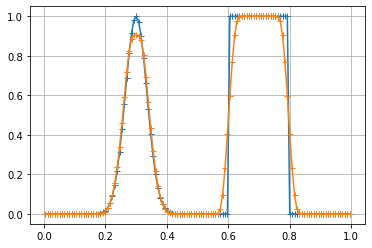

In [5]:
plt.plot(x,f,'+-') #plot f at the beginning
while (time<tend): #main time loop
    dt = min(dt, tend-time)
    time = time+dt
    #print (dt, time)
    #print(v, dt, dx)
    f = updated_f(f, v, dt, dx, method = 'linear', limiter = MClim)
    
plt.plot(x,f,'+-') #plot f at the end
#plt.axis([0,1,-0.5,1.5])
plt.grid()
plt.show()